# AMLT Lab#3

## Table of content

- [AMLT Lab#2](#AMLT-Lab2)
  - [Table of content](#table-of-content)
  - [Imports](#imports)
  - [Data](#data)
  - [Models](#models)
  - [Evaluation](#evaluation)
  - [Results](#results)

## Imports

In [1]:
import random
import warnings
import numpy as np
import tensorflow as tf
import keras.datasets as ds
import matplotlib.pyplot as plt
## tensorflow.propabilities is deprecated and removed with another lib called tfp
import tensorflow_probability as tfp
from prettytable import PrettyTable

In [2]:
np.random.seed(42)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
tf.compat.v1.disable_eager_execution()

## Data

In [3]:
train, test = ds.fashion_mnist.load_data()

X_train, y_train = train
X_test, y_test = test
X_train = X_train / 255
X_test = X_test / 255

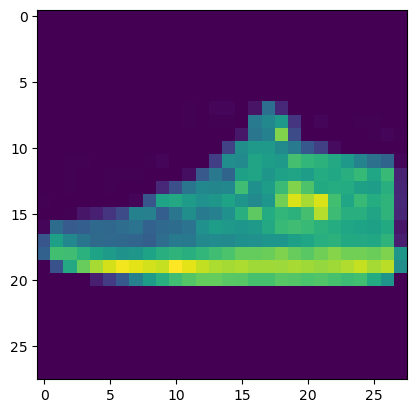

In [4]:
plt.imshow(X_train[random.randint(0, len(y_train))])

## Model

### Hyperparameters

In [22]:
params = {
    'encoder_layers': [256],
    'decoder_layers': [256],
    'picture_classification_layers': [256],   # for conditions
    'activation': tf.nn.sigmoid,
    'decoder_std': 0.5,                     # std for P(x|z)
    'z_dim': 10,                            # latent space dimension
    'picture_classification_weight': 10.0,    # for conditions
    'epochs': 51,
    'batch_size': 100,
    'learning_rate': 0.001,
}
num_pictures = 10

### Model

In [23]:
def encoder(x, layers):
    for layer in layers:
        x = tf.compat.v1.layers.dense(x,
                                  layer,
                                  activation=params['activation'])
    mu = tf.compat.v1.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.compat.v1.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.compat.v1.layers.dense(z,
                                  layer,
                                  activation=params['activation'])
    mu = tf.compat.v1.layers.dense(z, 784)
    return tf.nn.sigmoid(mu)


def picture_classification(x, layers):
    for layer in layers:
        x = tf.compat.v1.layers.dense(x,
                                  layer,
                                  activation=params['activation'])
    logits = tf.compat.v1.layers.dense(x, 10)
    return logits

def plot_samples(samples):
    IMAGE_WIDTH = 1.2
    plt.figure(figsize=(IMAGE_WIDTH * num_pictures,
                        len(samples) * IMAGE_WIDTH))
    for epoch, images in enumerate(samples):
        for digit, image in enumerate(images):
            plt.subplot(len(samples),
                        num_pictures,
                        epoch * num_pictures + digit + 1)
            plt.imshow(image.reshape((28, 28)),
                       cmap='Greys_r')
            plt.gca().xaxis.set_visible(False)
            if digit == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 31),
                           verticalalignment='center',
                           horizontalalignment='right',
                           rotation=0,
                           fontsize=16)
            else:
                plt.gca().yaxis.set_visible(False)

images = tf.compat.v1.placeholder(tf.float32, [None, 784])
pictures1 = tf.compat.v1.placeholder(tf.int32, [None])
encoder_mu, encoder_var = encoder(images, params['encoder_layers'])
eps = tf.compat.v1.random_normal(shape=[tf.shape(images)[0], params['z_dim']], mean=0.0, stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps

pic_logits = picture_classification(images, params['picture_classification_layers'])
pic_prob = tf.nn.softmax(pic_logits)

decoded_images = decoder(tf.concat([z, pic_prob], axis=1), params['decoder_layers'])

loss_reconstruction = -tf.reduce_sum(
    tfp.distributions.Normal(
        decoded_images,
        params['decoder_std']
    ).log_prob(images),
    axis=1
)

loss_prior = -0.5 * tf.reduce_sum(
    1 + tf.compat.v1.log(encoder_var) - encoder_mu ** 2 - encoder_var,
    axis=1
)

loss_auto_encode = tf.reduce_mean(
    loss_reconstruction + loss_prior,
    axis=0
)

loss_picture_classification = params['picture_classification_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=pictures1,
                                                   logits=pic_logits),
    axis=0
)

loss = loss_auto_encode + loss_picture_classification

train_op = tf.compat.v1.train.AdamOptimizer(params['learning_rate']).minimize(loss)

## Init

In [24]:
samples = []
losses_auto_encode = []
losses_picture_classification = []
losses_results = []
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    for epoch in range(params['epochs']):
        batch_1 = int(X_train.shape[0] / params['batch_size'])
        for i in range(batch_1):
            batch_images = X_train[i*params['batch_size']:(i+1)*params['batch_size']]
            batch_images2 = y_train[i*params['batch_size']:(i+1)*params['batch_size']]
            batch_images = np.reshape(batch_images, (params['batch_size'], 784))
            batch_images2 = np.reshape(batch_images2, (params['batch_size'],))
            sess.run(train_op, feed_dict={images: batch_images, pictures1: batch_images2})

        loss_autoenc, loss_classification = sess.run([loss_auto_encode, loss_picture_classification],
                                                                            {images: np.reshape(X_train, (X_train.shape[0], 784)),
                                                                            pictures1: np.reshape(y_train, (y_train.shape[0], )) })
        losses_auto_encode.append(loss_autoenc)
        losses_picture_classification.append(loss_classification)
        losses_results.append(loss_autoenc + loss_classification)

        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[10, 1])
        gen_samples = sess.run(decoded_images,feed_dict={z: sample_z, pic_prob: np.eye(10)})
        samples.append(gen_samples)

## Legacy

In [8]:
loss_plot_512 = np.array(losses_auto_encode) + np.array(losses_picture_classification)
loss_512 = losses_results

In [18]:
loss_plot_128 = np.array(losses_auto_encode) + np.array(losses_picture_classification)
loss_128 = losses_results

## Results

In [25]:
losses_tab = PrettyTable()
losses_tab.add_column('Iteration', ['Loss_128', 'Loss_256', 'Loss_512'])
for inx, val in enumerate(losses_results):
    if inx % 5 ==0:
        losses_tab.add_column(f'It#{inx}', [np.round(loss_128[inx], 1), np.round(val, 1), np.round(loss_512[inx], 1)])
print(losses_tab)

+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Iteration |  It#0 |  It#5 | It#10 | It#15 | It#20 | It#25 | It#30 | It#35 | It#40 | It#45 | It#50 |
+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|  Loss_128 | 247.9 | 225.7 | 221.5 | 219.3 | 218.0 | 217.2 | 216.7 | 216.1 | 215.9 | 215.3 | 215.1 |
|  Loss_256 | 241.1 | 223.9 | 220.1 | 217.9 | 216.8 | 215.9 | 215.2 | 214.8 | 214.4 | 214.0 | 213.8 |
|  Loss_512 | 238.1 | 223.6 | 219.6 | 217.3 | 216.1 | 215.2 | 214.5 | 214.2 | 213.6 | 213.4 | 212.8 |
+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+


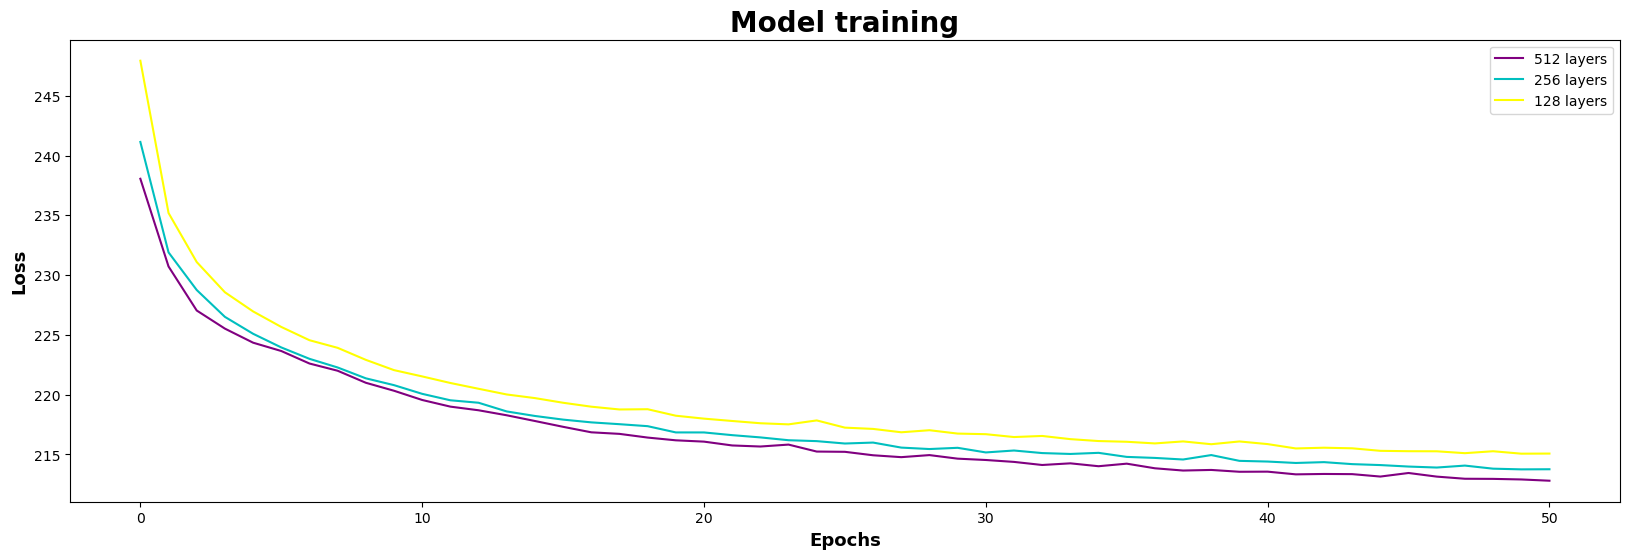

In [27]:
plt.figure(figsize=(20,6))
plt.plot(loss_plot_512, 'r', label='512 layers', color='purple')
plt.plot(np.array(losses_auto_encode) + np.array(losses_picture_classification), label='256 layers', color='c')
plt.plot(loss_plot_128, label='128 layers', color='yellow')
plt.title('Model training', fontsize=20, fontweight='bold')
plt.ylabel('Loss', fontsize=13, fontweight='bold')
plt.xlabel('Epochs', fontsize=13, fontweight='bold')
plt.legend()

## Conclusion

1. As you can see from the loss graph, setting the number of **epochs above 30 has** almost **no effect** on the result, while already **10-15 epochs show excellent** results.
2. Looking at the loss graph and the pictures below, you can see that the increase in **image quality depending on the number of layers is not critically large**. If the difference **between 128 layers and 256 is noticeable,** then there is practically **no difference between 256 and 512 layers**.

From this, I conclude that for the task of this dataset, <ins>**the optimal parameters will be + -25 epochs and 256 layers**</ins>.

### 128 layers

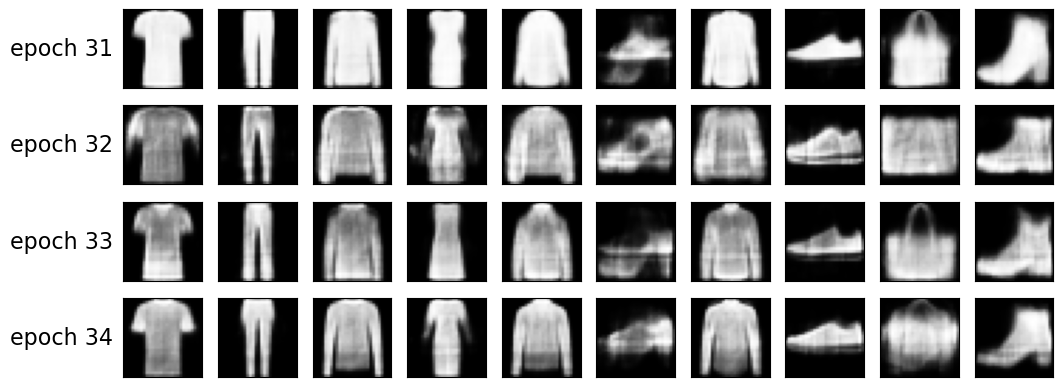

In [21]:
plot_samples(samples[30:34])

### 256 layers

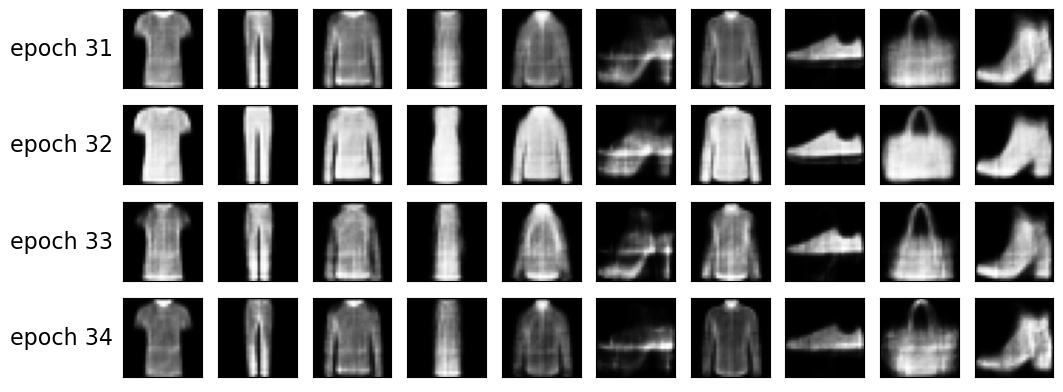

In [28]:
plot_samples(samples[30:34])

### 512 layers

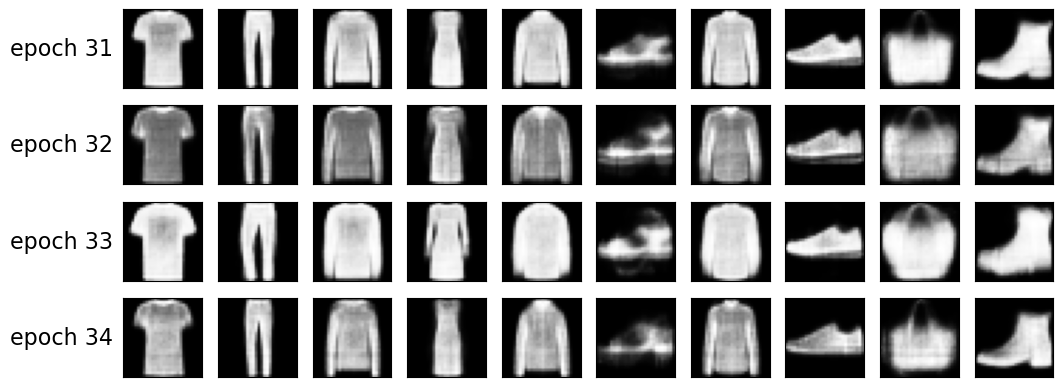

In [14]:
plot_samples(samples[30:34])